# Hands-On Tabular Workshop: *Detecting Fraud in Transaction Data - Seldon Core V2 Pipeline*

This workshop is focused on the creation, deployment, monitoring and management of a machine learning model for performing fraud detection. 

In this notebook you will be exploring the data, and training the machine learning model itself; in the form of an XGBoost classifier. You will then begin to add the advanced monitoring and explainability which Seldon Alibi is famed for. We will deploy our trained model and monitoring components as part of a Seldon Core V2 Pipeline and view these running pipelines in the Seldon Deploy Advanced UI. We will deploy our model using MLServer, which is on open source inference server for ML models. MLServer has support for for the [standard V2 Inference Protocol](https://docs.seldon.io/projects/seldon-core/en/latest/reference/apis/v2-protocol.html) on both the gRPC and REST flavours, which has been standardised and adopted by various model serving frameworks. Full MLServer docs can be found [here](https://mlserver.readthedocs.io/en/latest/).

We will also see Multi-Model Serving in action, as each of our Core V2 Pipelines will be served on the same instance of MLServer, really speaking to infrastructure optimisation in terms of reducing the amount of infrastructure that we would need to run and maintain.

The EDA and training of models within this notebook is heavily inspired by the fantastic work of Arjun Joshua, you can find the original [here](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services/notebook). 

-----------------------------------
Firstly, you install and import the relevant packages which we will use throughout the exploration and training process. 

In [ ]:
!pip install alibi==0.8.0
!pip install alibi_detect==0.8.1
!pip install dill
!pip install seaborn
!pip install seldon_deploy_sdk
!pip install xgboost==1.5.2
!pip install mlserver

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import yaml

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer

from alibi.explainers import AnchorTabular
from alibi_detect.cd import MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator
from seldon_deploy_sdk import Model, ModelsApi, PipelinesApi

# For repeatability
randomState = 5
np.random.seed(randomState)

You then download the dataset which you will be using for the workshop, and load it into a Pandas DataFrame.

In [3]:
!gsutil cp gs://kelly-seldon/fraud-detection-scv2/data/transaction-data.csv data/transaction-data.csv

Copying gs://kelly-seldon/fraud-detection-scv2/data/transaction-data.csv...
| [1 files][470.7 MiB/470.7 MiB]    8.1 MiB/s                                   
Operation completed over 1 objects/470.7 MiB.                                    


In [4]:
df = pd.read_csv('data/transaction-data.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


It is worth taking a second to understand the features (columns of the table) within the dataset:
* `step`: This is a time series data set i.e. money transfers occur over time. 1 step represents 1 hour, with a total of 744 steps equivalent to 30 days. 
* `type`: The type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER.
* `amount`: Amount of the transaction in local currency.
* `nameOrig`: Customer name who started the transaction.
* `oldBalanceOrig`: Initial balance before the transaction.
* `newBalanceOrig`: New balance after the transaction.
* `nameDest`: Customer name who is the recipient of the transaction.
* `oldBalanceDest`: Initial balance of the recipient before the transaction.
* `newBalanceDest`: New balance of the recipient after the transaction.
* `isFraud`: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* `isFlaggedFraud`: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

It is worth noting that this is a synthetically generated dataset and so does not represent real world transactions, but is based upon the behaviour of a supplied real world dataset. You can read more about the data used [here](https://www.kaggle.com/ntnu-testimon/paysim1).

## Data Preparation

There are a number of data preparation steps which need to be performed prior to visualisation and model training. The first of which is to remove all transaction types apart from TRANSFER and CASH_OUT. These are the only transaction types where fraud occurs, and therefore the other types of transaction can be neglected. 

In [3]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

Next, you can remove a number of the feature columns which have no predictive power. These are the account name fields, as well as the `isFlaggedFraud` which has no clear relation to the other features. 

In [4]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

You can then encode the transaction type categorical feature as a binary. Transactions types of TRANSFER will be 0, meanwhile CASH_OUT transactions will be 1. 

In [5]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

You now create the labels. This will simply be the `isFraud` field, and will be what your machine learning model attempts to predict based on the remaining transaction features. 

In [6]:
Y = X['isFraud']
del X['isFraud']

#### Working with Zero Balances

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).


Since the destination account balances being zero is a strong indicator of fraud we replace the values of oldBalanceDest and newBalanceDest with -1 where they are 0 originally, but have a non-zero transfer between them. 

In [7]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = -1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. Once again, the fraction of such transactions is much smaller in fraudulent (47%) compared to genuine transactions (0.3%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with -1.

In [8]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 

In [9]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

## Data Visualisation

Let's explore the data by generating a series of plots. 

First create a function which allows you to generate strip plots readily.

In [10]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x = x, y = y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 14);
    return ax

Let's compare how genuine and fraudulent transacations are distributed over time. 

/tmp/ipykernel_607683/3349969187.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
/home/seldon/anaconda3/envs/fraud-mlserver/lib/python3.8/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/tmp/ipykernel_607683/1968354904.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)


Text(0, 0.5, 'time [hour]')

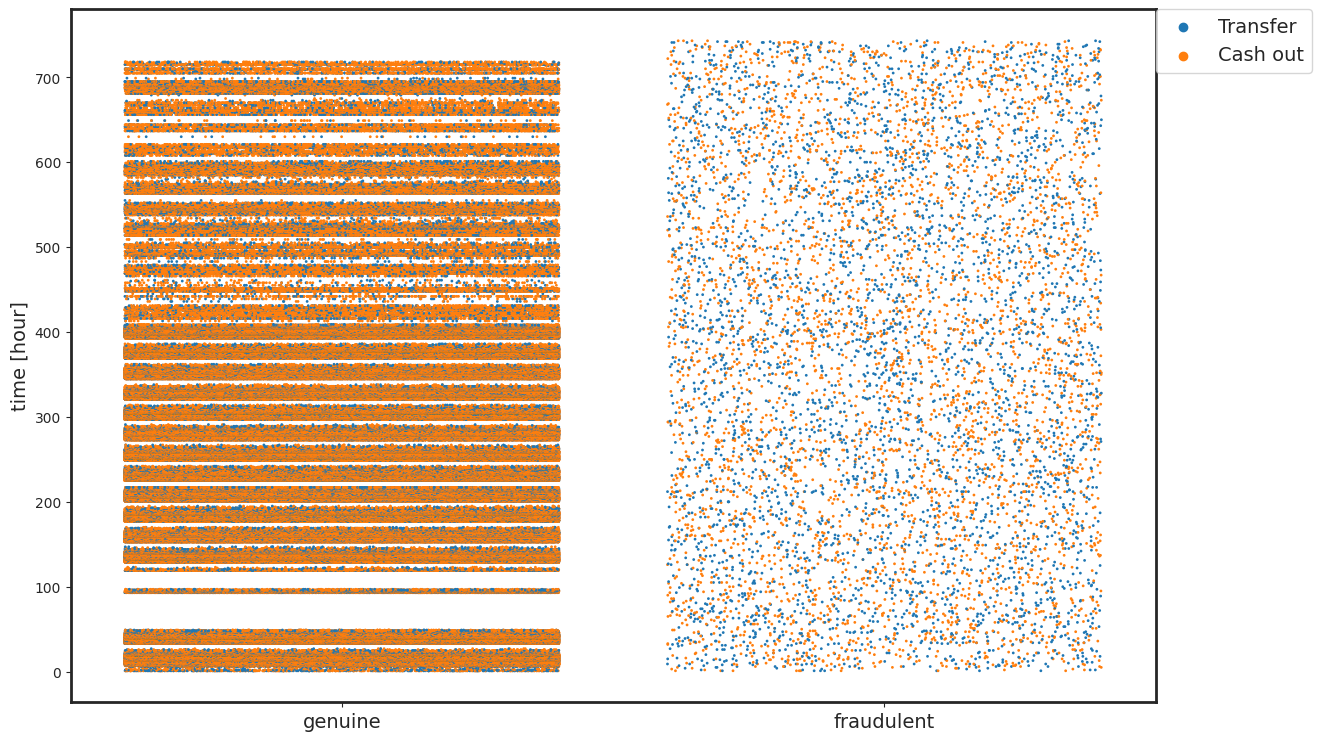

In [11]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 14)

You can see that genuine transactions have a more regular pattern, occuring at intervals with periods in between which do not see any genuine transactions occuring. These periods could represent weekends or holidays resulting in businesses being closed. Meanwhile, the fraudulent transactions are far more evenly distributed, with no discernible pattern. 

Furthermore, it's clear that the majority of genuine transcations are of type CASH OUT, whereas fraudulent transactions feature TRANSFER types far more prominently. 

-----

Next, compare the transfer amount distributions for genuine and fraudulent transctions. 

/tmp/ipykernel_607683/2130531187.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
/home/seldon/anaconda3/envs/fraud-mlserver/lib/python3.8/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/tmp/ipykernel_607683/1968354904.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)


Text(0, 0.5, 'amount')

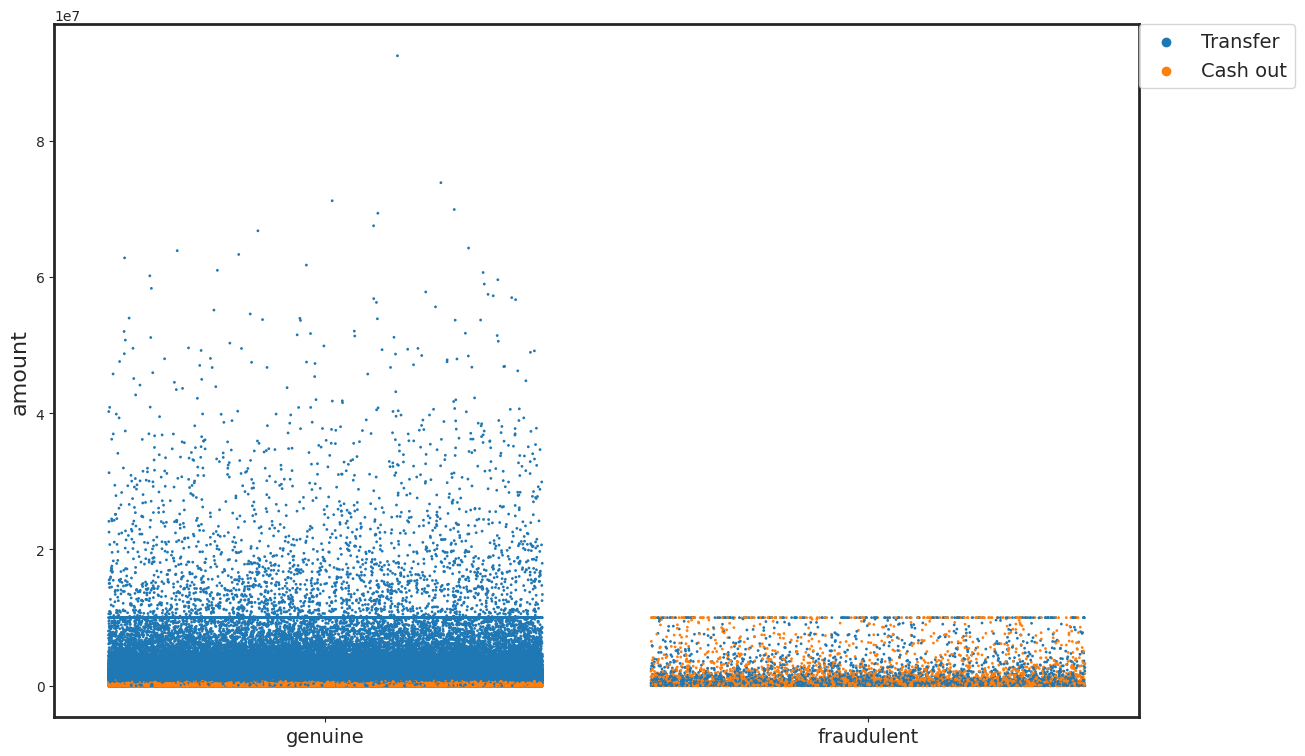

In [12]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)

There is no clear pattern between genuine and fraudulent transactions by simply considering the amount. However, it appears there is a ceiling on the limit of a fraudulent transaction (10,000,000).

-----

Finally, you visualise the feature you created earlier `errorBalanceDest`, which is simply calculated by taking the previous balance of the destination account, plus the amount which was transferred minus new balance in the account. 

Remember, that many of the fraudulent transactions we observed had 0 account balance both before and after a non-zero sum of money was transferred. Therefore, the `errorBalanceDest` of these transactions will be a positive number equivalent to the value of the transfer.

/tmp/ipykernel_607683/2731409023.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], X.errorBalanceDest[:limit], X.type[:limit], \
/home/seldon/anaconda3/envs/fraud-mlserver/lib/python3.8/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/tmp/ipykernel_607683/1968354904.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)


Text(0, 0.5, 'errorBalanceDest')

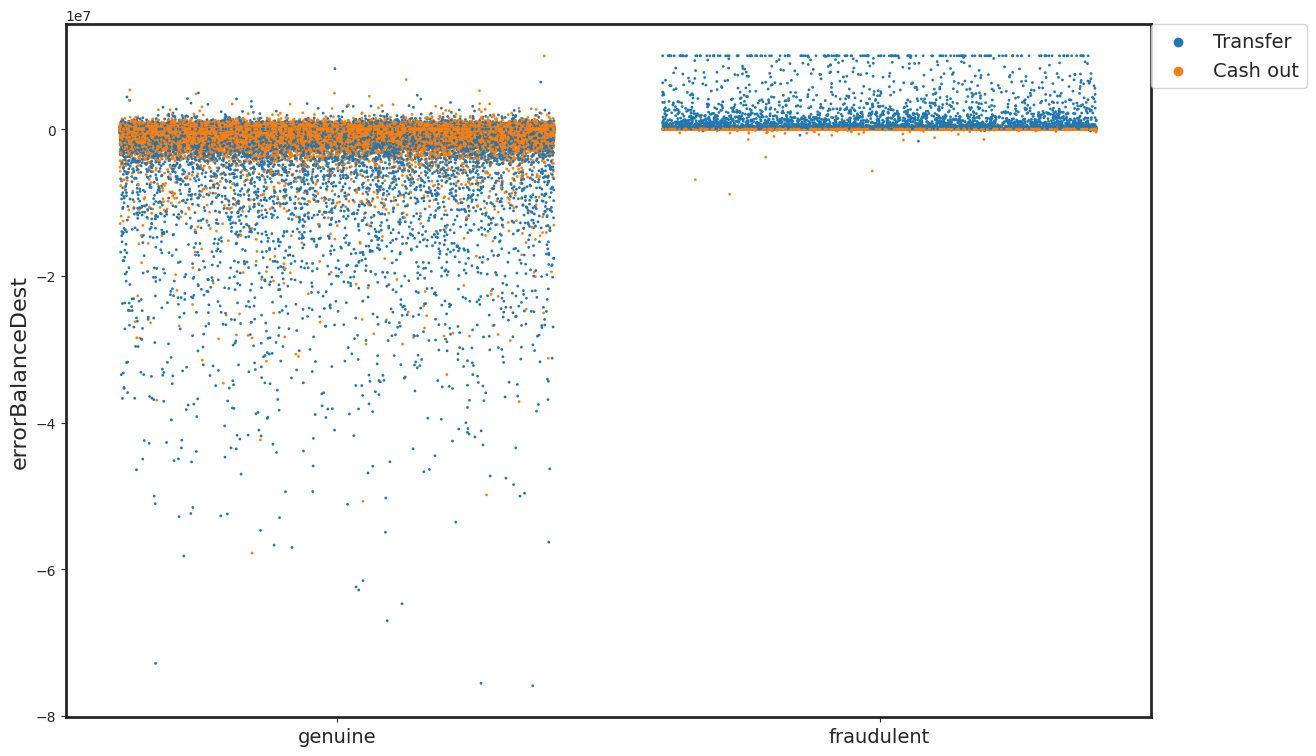

In [13]:
limit = len(X)
ax = plotStrip(Y[:limit], X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('errorBalanceDest', size = 16)

From this figure we can see a clear distinction between genuine and fraudulent transactions with positive errorBalanceDest being recorded overwhelmingly more so for fraudulent transactions than genuine ones. 

# Model Training

Next you will train your predictor, to determine in an automated fashion whether a new transaction is fraudulent or not. 

You will be using an XGBoost classifier as it is naturally suited to handling such an imbalanced dataset, whereby only 0.3% of the transactions are fraudulent. 

In [14]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


You split your data into training and testing sets. 

In [15]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

You also weight the positive class (fraudulent) more than the negative class (genuine) to help account for the overrepresentation of genuine transactions in the dataset. 

In [16]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

You then train and score an XGBoost classifier. 

In [17]:
# Long computation in this cell (~3 minutes)

clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4, use_label_encoder=False)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

/home/seldon/anaconda3/envs/fraud-mlserver/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:20:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9984747968838775


A very impressive 0.99 AUPRC! Which means your classifier is accurately distinguishing between transactions. 

You can visualise the features which are most important to your new XGBoost classifier as shown below. 

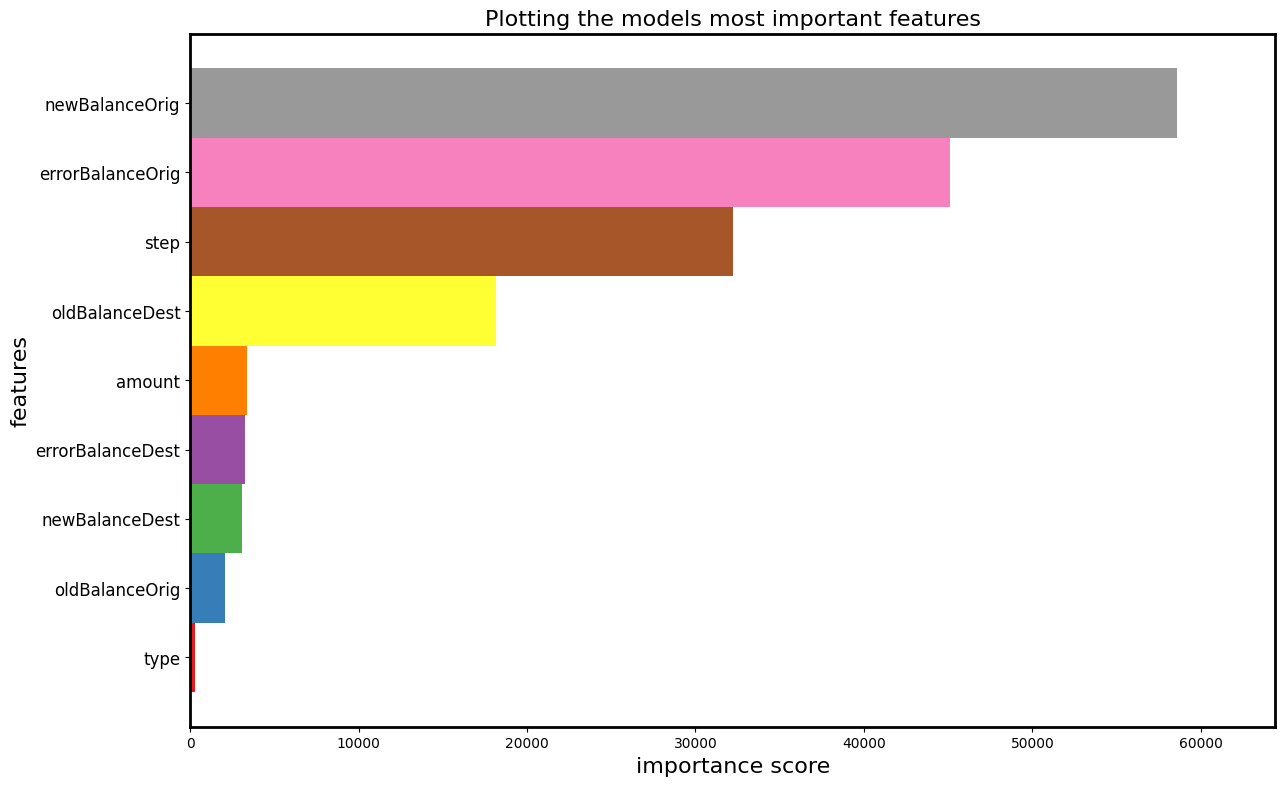

In [18]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Plotting the models most important features', size = 16);

You can now save your model, and upload it to an artefact store (in this case a Google storage bucket) ready for deployment.

You will be making use of the pre-packaged XGBoost model server, and therefore Seldon expects your classifier to be saved as `model.bst`. 

In [19]:
clf.save_model('model.bst')

You will now upload our saved model file to a Google storage bucket. 

### ⚠️ IMPORTANT ⚠️
Make sure you fill in the YOUR_NAME variable to ensure you're not overwriting existing artefacts.

In [20]:
YOUR_NAME = "kelly"

!gsutil cp model.bst gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][ 64.2 KiB/ 64.2 KiB]                                                
Operation completed over 1 objects/64.2 KiB.                                     


## Model Deployment
You can now deploy your model to the dedicated Seldon Deploy cluster which you have configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that. 

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the `SD_IP` variable to be the same as the cluster you are using. 

In [21]:
SD_IP = "34.32.140.43"

config = Configuration()
config.host = f"https://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"https://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"
config.verify_ssl = False

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup your authentication function you can describe the model you would like to create. 

You will need to fill in the `MODEL_NAME`, `NAMESPACE`, and the `MODEL_LOCATION`, the rest of the model description has been templated for you. 

For the `MODEL_LOCATION` you do not need to specify the path all the way up to `model.bst` e.g. if you saved your classifier under `gs://kelly-seldon/fraud-detection-scv2/kelly/models/model.bst` your `MODEL_LOCATION` should be `gs://kelly-seldon/fraud-detection-scv2/kelly/models` and Seldon will automatically pick up the classifier artifact stored there. 

In [23]:
MODEL_NAME = f"fraud-{YOUR_NAME}"
NAMESPACE = "seldon"
MODEL_LOCATION = f"gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models"

In [24]:
model = {
    "apiVersion": "mlops.seldon.io/v1alpha1",
    "kind": "Model",
    "metadata": {
        "name": MODEL_NAME,
        "namespace": NAMESPACE
    },
  "spec": {
    "storageUri": MODEL_LOCATION,
    "requirements": [
      "xgboost"
    ],
    "memory": "1Gi"
  }
}

In [25]:
model_api = ModelsApi(auth())
model_api.create_model(namespace=NAMESPACE, model=model)

{'api_version': None,
 'kind': None,
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': '2023-07-02T08:22:45Z',
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': 1,
              'labels': None,
              'managed_fields': [{'api_version': 'mlops.seldon.io/v1alpha1',
                                  'fields_type': 'FieldsV1',
                                  'fields_v1': {'f:spec': {'.': {},
                                                           'f:memory': {},
                                                           'f:requirements': {},
                                                           'f:storageUri': {}}},
                                  'manager': 'deployserver',
                                  'operation': 'Update',
                                  'time': '2

Next you can describe the pipeline you would like to create. 

You will need to fill in the `PIPELINE_NAME`, the rest of the pipeline description has been templated for you. 

In [ ]:
PIPELINE_NAME = f"fraud-detect-{YOUR_NAME}"

In [27]:
pipeline = f"""
apiVersion: mlops.seldon.io/v1alpha1
kind: Pipeline
metadata:
  name: {PIPELINE_NAME}
  namespace: {NAMESPACE}
spec:
  steps:
    - name: {MODEL_NAME}
  output:
    steps:
    - {MODEL_NAME}
"""

pipeline = yaml.safe_load(pipeline)

In [28]:
pipelines_api = PipelinesApi(auth())
pipelines_api.create_pipeline(namespace=NAMESPACE, mldeployment=pipeline)

{'api_version': None,
 'kind': None,
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': '2023-07-02T08:22:52Z',
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': 1,
              'labels': None,
              'managed_fields': [{'api_version': 'mlops.seldon.io/v1alpha1',
                                  'fields_type': 'FieldsV1',
                                  'fields_v1': {'f:spec': {'.': {},
                                                           'f:output': {'.': {},
                                                                        'f:steps': {}},
                                                           'f:steps': {}}},
                                  'manager': 'deployserver',
                                  'operation': 'Update',
                                  't

You can access the Seldon Deploy cluster and view your freshly created pipeline here: 

Again, make sure to replace XXXXX with your cluster IP.

* URL: http://XXXXX/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

## Adding a Prediction Schema & Metadata
Seldon Deploy has a model catalog where all deployed models are automatically registered. The model catalog can store custom metadata as well as prediction schemas for your models. 

Metadata promotes lineage from across different machine learning systems, aids knowledge transfer between teams, and allows for faster deployment. Meanwhile, prediction schemas allow Seldon Deploy to automatically profile tabular data into histograms, allowing for filtering on features to explore trends. 

In order to effectively construct a prediction schema Seldon has the [ML Prediction Schema](https://github.com/SeldonIO/ml-prediction-schema) project. The first step is to determine your datatypes. 

In [29]:
trainX.dtypes

step                  int64
type                  int64
amount              float64
oldBalanceOrig      float64
newBalanceOrig      float64
oldBalanceDest      float64
newBalanceDest      float64
errorBalanceOrig    float64
errorBalanceDest    float64
dtype: object

From this you can construct the prediction schema object below, which maps the data types to the requests and responses which the model returns. 

In [30]:
prediction_schema = {
  "requests": [
    {
      "name": "step",
      "type": "REAL",
      "dataType": "INT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "type",
      "type": "REAL",
      "dataType": "INT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "amount",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "oldBalanceOrig",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "newBalanceOrig",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "oldBalanceDest",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "newBalanceDest",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "errorBalanceOrig",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    },
    {
      "name": "errorBalanceDest",
      "type": "REAL",
      "dataType": "FLOAT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    }
  ],
  "responses": [
    {
      "name": "Likelihood of Fraud",
      "type": "REAL",
      "dataType": "INT",
      "nCategories": "0",
      "categoryMap": {},
      "schema": [],
      "shape": []
    }
  ]
}

You then add the prediction schema to the wider model catalog metadata. This includes information such as the model storage location, the name, who authored the model etc. The metadata tags and metrics which can be associated with a model are freeform and can therefore be determined based upon the use case which is being developed. 

In [32]:
model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": f"{MODEL_NAME}-model",
      "version": "v1.0",
      "artifactType": "XGBOOST",
      "taskType": "fraud classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "project": "default",
      "prediction_schema": prediction_schema
    }

model_catalog_metadata

{'URI': 'gs://kelly-seldon/fraud-detection-scv2/kelly/models',
 'name': 'fraud-model',
 'version': 'v1.0',
 'artifactType': 'XGBOOST',
 'taskType': 'fraud classification',
 'tags': {'auto_created': 'true', 'author': 'kelly'},
 'metrics': {},
 'project': 'default',
 'prediction_schema': {'requests': [{'name': 'step',
    'type': 'REAL',
    'dataType': 'INT',
    'nCategories': '0',
    'categoryMap': {},
    'schema': [],
    'shape': []},
   {'name': 'type',
    'type': 'REAL',
    'dataType': 'INT',
    'nCategories': '0',
    'categoryMap': {},
    'schema': [],
    'shape': []},
   {'name': 'amount',
    'type': 'REAL',
    'dataType': 'FLOAT',
    'nCategories': '0',
    'categoryMap': {},
    'schema': [],
    'shape': []},
   {'name': 'oldBalanceOrig',
    'type': 'REAL',
    'dataType': 'FLOAT',
    'nCategories': '0',
    'categoryMap': {},
    'schema': [],
    'shape': []},
   {'name': 'newBalanceOrig',
    'type': 'REAL',
    'dataType': 'FLOAT',
    'nCategories': '0',
   

Next, using the metadata API you can add this to the model which you have just created in Seldon.

In [33]:
metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

{}

You can then list the metadata via the API, or view it in the UI, to confirm that it has been successfully added to the model. 

In [ ]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
metadata_response

You can now send requests to your model. It is worth noting that here we are sending requests with tensors for each input feature.

An example of a normal transaction:

```
{
	"parameters": {
		"content_type": "pd"
	},
	"inputs": [{
			"name": "step",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [205]
		},
		{
			"name": "type",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [1]
		},
		{
			"name": "amount",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [63243.44]
		},
		{
			"name": "oldBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [-1.00]
		},
		{
			"name": "newBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [-1.00]
		},
		{
			"name": "oldBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [1853683.32]
		},
		{
			"name": "newBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [1916926.76]
		},
		{
			"name": "errorBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [63243.44]
		},
		{
			"name": "errorBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		}
	]
}
```
And a fraudulent transaction too:

```
{
    "parameters": {
		"content_type": "pd"
	},
	"inputs": [
        {
			"name": "step",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [629]
		},
		{
			"name": "type",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [1]
		},
		{
			"name": "amount",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "oldBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "newBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "oldBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "newBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "errorBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "errorBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		}
	]
}
```

# Drift Detection

In this example you will use Alibi Detect to train a custom drift detector which can flag when the underlying input data distribution has shifted. This can inform decisions about re-training or prompt deeper investigation into data/model behaviours.

Seldon Deploy also allows you to setup alerts when drift is detected.

In this example you will use the Maximum Mean Discrepancy method. Covariate or input drift detection relies on creating a distance measure between two distributions; a reference distribution and a new distribution. The MMD drift detector is no different; the mean embeddings of your features are used to generate the distributions and then the distance between them is measured. The training data is used to calculate the reference distribution, while the new distribution comes from your inference data.

More technically, a reproducing kernel Hilbert space is used to generate the mean embeddings, by mapping the highly complex feature space within which most machine learning models operate to a linear Euclidean space. A radial basis function kernel is then used to measure the distance between the two embeddings, and the signifiance of the drift is calculated as a p-value using permutation/resampling tests. More details can be found here.

In this case you will train your drift detector on a sample of 5000 instances from the training set. This has been picked for convenience and speed of training in the workshop, and if this was a production case you would likely want to use the entirety of the training set, or a statistically significant segment.

In [34]:
cd = MMDDrift(trainX.iloc[:5000].to_numpy(), backend='tensorflow', p_val=.05)

2023-07-02 09:25:59.898951: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100000000 exceeds 10% of free system memory.
2023-07-02 09:25:59.993917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100000000 exceeds 10% of free system memory.
2023-07-02 09:26:00.149053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100000000 exceeds 10% of free system memory.
2023-07-02 09:26:00.255446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100000000 exceeds 10% of free system memory.
2023-07-02 09:26:00.277012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100000000 exceeds 10% of free system memory.


Now you can test your drift detector locally:

In [37]:
preds = cd.predict(testX.iloc[100:200].to_numpy(), return_p_val=True, return_distance=True)
preds

{'data': {'is_drift': 0,
  'distance': -0.0014184117,
  'p_val': 0.59,
  'threshold': 0.05,
  'distance_threshold': 0.0059405565},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.8.1',
  'backend': 'tensorflow'}}

You can then save the drift detector, and upload it to the GS bucket. 

In [38]:
save_detector(cd, "fraud-drift-detector")

Directory fraud-drift-detector does not exist and is now created.


In [39]:
!gsutil cp -r fraud-drift-detector gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models/fraud-drift-detector

Copying file://fraud-drift-detector/MMDDriftTF.dill [Content-Type=application/octet-stream]...
Copying file://fraud-drift-detector/meta.dill [Content-Type=application/octet-stream]...
- [2 files][352.2 KiB/352.2 KiB]                                                
Operation completed over 2 objects/352.2 KiB.                                    


Next we will deploy our drift detector through the Seldon Deploy UI. 

Here we will be deploying a drift detector that works at a batch level rather than a feature level. Going through the UI, if you navigate to your Pipeline and then go to the top of the "Dashboard" and click to "Add" a drift detector. The fields that you will need to change are as follows: 

1. Add a detector name, for example `kelly-dd`
2. Add your storage URI, this will be: ` gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models/fraud-drift-detector` but ensure you replace `{YOUR_NAME}` with the actual value of the variable 
3. Change the `Minimum Batch Size` to be `5` and select `Batch`

Now you are ready to `Create Detector`

You can now test the drift detector by sending the same request multiple times, this should show that data drift is occurring. 

# Explainer
Next, you will train an explainer to glean deeper insights into the decisions being made by your model. 

You will make use of the Anchors algorithm, which has a [production grade implementation available](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) using the Seldon Alibi Explain library. 

The first step will be to write a simple prediction function which the explainer can call in order to query your XGBoost model. 

In [42]:
def predict_fn(x):
    return clf.predict_proba(x)

You then initialise your Anchor explainer, using the AnchorTabular flavour provided by Alibi due to your data modality. 

The AnchorTabular class expects the prediction function which you defined above, as well as a list of the feature names. You can find a sample notebook in the Alibi docs [here](https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_tabular_adult.html). 

In [43]:
columns = list(trainX.columns)
explainer = AnchorTabular(predict_fn, columns)

You now need to fit your explainer object around some data so that it can learn to generate explanations based upon said data. 

As the training set is highly imbalanced (only a tiny fraction of the datapoints are fraudulent transactions) you create a new balanced set which is 50/50 normal/fraud transactions. This helps you to generate descriptive and useful explanations for both fraudulent and normal transactions.*

In the code block below you generate the new balanced set, and convert it to a numpy array as this is the type which Alibi expects. 

It is possible to generate a working explainer based upon the original dataset, but the anchors it identifies are not specific when considering normal transactions. The empty anchor is only ever returned due to the skew in the dataset. 

In [44]:
balanced_set = pd.concat([Xfraud, XnonFraud.iloc[:len(Xfraud)]]).to_numpy()

You then fit our explainer to your newly balanced data set. 

In [45]:
explainer.fit(balanced_set, disc_perc=(25, 50, 75)) 

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.8.0'}
)

You can now test your explainer on the test set, and view the explanations it begins to generate. Feel free to change the value of `idx` to see how it impacts the explanation generated. 

In [46]:
idx = 10

testX_array = testX.to_numpy()

class_names = ["Normal", "Fraudulent"]
print('Prediction: ', class_names[explainer.predictor(testX_array[idx].reshape(1, -1))[0]])

explanation = explainer.explain(testX_array[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Normal
Anchor: errorBalanceOrig > 158355.32
Precision: 0.99
Coverage: 0.25


Explicitly testing a fraudulent transaction. 

In [47]:
print('Prediction: ', class_names[explainer.predictor(testX.loc[6272989].to_numpy().reshape(1, -1))[0]])

explanation = explainer.explain(testX.loc[6272989].to_numpy(), threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Fraudulent
Anchor: errorBalanceOrig <= 0.00 AND amount > 731392.47
Precision: 1.00
Coverage: 0.20


You now save your explainer, and upload it to the GS bucket. You can use the explainer's built-in save method to do this easily and reproducibly. 

In [48]:
explainer.save("fraud-explainer")

In [49]:
!gsutil cp -r fraud-explainer gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models/fraud-explainer

Copying file://fraud-explainer/explainer.dill [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://fraud-explainer/meta.dill [Content-Type=application/octet-stream]...
/ [2 files][191.5 MiB/191.5 MiB]    1.6 MiB/s                                   
Operation completed over 2 objects/191.5 MiB.               

In [50]:
%%writefile model-settings.json 
{
    "implementation": "mlserver_alibi_explain.AlibiExplainRuntime"
}

Overwriting model-settings.json


In [52]:
!gsutil cp -r model-settings.json gs://kelly-seldon/fraud-detection-scv2/{YOUR_NAME}/models/fraud-explainer/model-settings.json

Copying file://model-settings.json [Content-Type=application/json]...
/ [1 files][   71.0 B/   71.0 B]                                                
Operation completed over 1 objects/71.0 B.                                       


Again, you can now deploy your new explainer via the Seldon Deploy UI.

We can then send some further requests and generate local explainations for the given responses: 

An example of a normal transaction:

```
{
	"parameters": {
		"content_type": "pd"
	},
	"inputs": [{
			"name": "step",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [205]
		},
		{
			"name": "type",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [1]
		},
		{
			"name": "amount",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [63243.44]
		},
		{
			"name": "oldBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [-1.00]
		},
		{
			"name": "newBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [-1.00]
		},
		{
			"name": "oldBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [1853683.32]
		},
		{
			"name": "newBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [1916926.76]
		},
		{
			"name": "errorBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [63243.44]
		},
		{
			"name": "errorBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		}
	]
}
```
And a fraudulent transaction too:

```
{
    "parameters": {
		"content_type": "pd"
	},
	"inputs": [
        {
			"name": "step",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [629]
		},
		{
			"name": "type",
			"shape": [1, 1],
			"datatype": "INT32",
			"data": [1]
		},
		{
			"name": "amount",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "oldBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "newBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "oldBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "newBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [2433009.28]
		},
		{
			"name": "errorBalanceOrig",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		},
		{
			"name": "errorBalanceDest",
			"shape": [1, 1],
			"datatype": "FP32",
			"data": [0.00]
		}
	]
}
```

# Congratulations!

Thank you for sticking it out to the end of the workshop! 

As a recap you have done the following: 
1. Cleaned and explored a set of transaction data.
2. Trained an XGBoost model to distinguish between normal and fraudulent payments. 
3. Added metadata and a prediction schema. 
4. Trained and deployed a drift detector to understand when your data changes. 
5. Added an explainer to gain deeper insights into the model's behaviour!

Not a bad list. Well done, you!